In [514]:
%matplotlib inline
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim
from coolname import generate_slug as name
import yaml
from sklearn import datasets
from sklearn.utils import shuffle

In [515]:
zero_ins = []
one_ins = []

In [516]:
def zero_grad(self, grad_input, grad_output):
    temp = list(grad_input)
    #Temp[2] is the gradients to the weights, zero them out so they cant change. 
    temp[2] *= torch.transpose(self.mask,0, 1)
    return tuple(temp)

class SparseNet(nn.Module):
    def __init__(self, weights, biases, masks):
        super(SparseNet, self).__init__()
        self.act_log = None
        self.err_log = None
        self.layers = nn.ModuleList()
        self.masks = masks
        self.out = None
        for w, b, m in zip(weights,biases,masks):
            temp = nn.Linear(w.shape[1],w.shape[0])
            temp.weight.data = torch.from_numpy(w.astype(np.float32))
            temp.bias.data = torch.from_numpy(b.astype(np.float32))
            temp.mask = torch.from_numpy(m.astype(np.float32))
            temp.register_backward_hook(zero_grad)
            self.layers.append(temp)

    def forward(self, x, log=False):
        self.log = log
        
        for l in self.layers[:-1]:
            y = l(x)
            x = torch.cat((x,y),1)
            x = F.relu(x)
        self.out = self.layers[-1](x)
        
        if(log):
            self.out.retain_grad()
            if self.act_log is None:
                self.act_log = x.detach()
            else:
                self.act_log = torch.cat((self.act_log,x.detach()), dim=0)
            
        return self.out
    
    def clear(self):
        self.act_log = None
        self.err_log = None

    def dumpweights(self):
        weights = []
        biases = []
        for l in self.layers:
            weights.append(l.weight.data.numpy().astype(np.float64))
            biases.append(l.bias.data.numpy().astype(np.float64))
        return weights, biases

class graph_neural_network():
    def __init__(self,n_in,n_out,h_edges=3,in_names = None, out_names = None):
        self.G = nx.DiGraph()
        self.h_edges = h_edges
        self.inputs = in_names
        self.outputs = out_names
        if in_names is None:
            self.inputs = ["(in)"+name() for i in range(n_in)]
        if out_names is None:
            self.outputs = ["(out)"+name() for i in range(n_out)]
        self.flat = None
        for i in self.inputs:
            self.G.add_node(i) 
        for o in self.outputs:
            self.G.add_node(o)
            self.G.node[o]['bias'] = np.random.normal(0,1) 
        self.hidden = []
    
    def add_hidden(self,incoming,outgoing):
        h = name()
        #print(incoming,outgoing)
        edges = []
        for i in incoming:
            edges.append((i,h,np.random.normal(0,1.0/self.h_edges)))
        
        approx_xavier = len(self.outputs) * 1.0/ (1+len(self.hidden))
        
        for o in outgoing:
            edges.append((h,o,np.random.normal(0,approx_xavier)))
            
        self.G.add_weighted_edges_from(edges)
        self.G.node[h]['bias'] = random.uniform(-.1,.1)
        self.hidden.append(h)
    
    def add_random_hidden(self):
        incoming = [random.choice(self.inputs+self.hidden) for i in range(self.h_edges)]
        outgoing = [random.choice(self.outputs)]
        self.add_hidden(incoming,outgoing)
    
    def get_layers(self):
        G = self.G
        G2 = nx.topological_sort(G)
        max_layer = 0
        for n in G2:
            if n not in self.outputs:
                G.node[n]['layer'] = max([G.node[k[0]]['layer'] for k in G.in_edges(n)] + [-1]) + 1
                max_layer = max(max_layer,G.node[n]['layer'])
        for n in self.outputs:
            G.node[n]['layer'] = max_layer + 1

        layers = [[] for _ in range(max_layer + 2)]

        for n in G:
            layers[G.node[n]['layer']].append(n)

        self.flat = []
        flat_idx = 0
        for i, layer in enumerate(layers):
            for j, n in enumerate(layer):
                G.node[n]['idx'] = j
                G.node[n]['flat_idx'] = flat_idx
                self.flat.append(n)
                flat_idx += 1
        
        return layers
    
    def get_output_idxes(self):
        outputs = self.outputs
        G = self.G
        out_idxes = []
        for n in G:
            if(n in outputs):
                out_idxes.append(G.node[n]['flat_idx'])
        return out_idxes
    
    def get_weights(self):
        G = self.G
        outputs = self.outputs
        
        layers = self.get_layers()
        mask = []    
        weights = []
        biases = []

        n_nodes = 0
        for i in range(len(layers) - 1):
            n_nodes += len(layers[i])
            mask.append(np.zeros((len(layers[i+1]),n_nodes)))
            biases.append(np.zeros((len(layers[i+1]))))
            weights.append(np.zeros((len(layers[i+1]),n_nodes)))

            for j, node1 in enumerate(layers[i+1]):
                biases[i][j] = G.node[node1]['bias']
                for node0, _ in G.in_edges(node1): 
                    u = G.node[node0]['flat_idx']
                    v = G.node[node1]['idx']
                    mask[i][v,u] = 1
                    weights[i][v,u] = G[node0][node1]['weight']

        return weights, biases, mask
    
    def set_weights(self,weights,biases):
        layers = self.get_layers()
        for i in range(len(layers) - 1):
            for j, node1 in enumerate(layers[i+1]):
                self.G.node[node1]['bias'] = biases[i][j]
                for node0, _ in self.G.in_edges(node1): 
                    u = self.G.node[node0]['flat_idx']
                    v = self.G.node[node1]['idx']
                    self.G[node0][node1]['weight'] = weights[i][v,u]
                    
    def create_nn(self):
        w, b, m = self.get_weights()
        self.nn = SparseNet(w,b,m)
    
    def update_graph(self):
        weights = [l.weight.data.numpy() for l in self.nn.layers]
        biases = [l.bias.data.numpy() for l in self.nn.layers]
        self.set_weights(weights,biases)
    
    def get_err_act_vectors(self,X,y):
        gnn.nn.clear()
        for j in range(len(X)):
            out = gnn.nn(X[j],log=True) 
            out = F.softmax(out,dim=1)
            loss = criterion(out,y[j])
            loss.backward()

            if gnn.nn.err_log is None:
                gnn.nn.err_log = gnn.nn.out.grad
            else:
                gnn.nn.err_log = torch.cat((gnn.nn.err_log,gnn.nn.out.grad), dim=0)
                

            optimizer.zero_grad()

        return gnn.nn.act_log, gnn.nn.err_log
    
    def add_cossim_hidden(self,X,y,out=None):
        
        act, err = self.get_err_act_vectors(X,y)
        if out is None:
            out = random.randint(0,len(self.outputs)-1)
        err = err[:,out:out+1]
        
        #print(act.size(),err.size())
        act = F.normalize(act)
        err = F.normalize(err)
        
        incoming = []
        toprint = []
        cossim = F.cosine_similarity(err,act,dim=0)
        _, choices = torch.topk(cossim.abs(),self.h_edges, dim=0)
        for choice in choices:
            incoming.append(self.flat[choice])
            toprint.append(("%.2f(" % cossim[choice]) + self.flat[choice]+")")
            if out == 0:
                zero_ins.append(self.flat[choice].split(","))
            if out == 1:
                one_ins.append(self.flat[choice].split(","))
            
        outgoing = [self.outputs[out]]
        print(toprint,"->",outgoing)
        
        self.add_hidden(incoming,outgoing)
        
        
        
        

In [517]:
use_cuda = torch.cuda.is_available()

root = './data'
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
def imshow(img):
    img = img / 2 + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


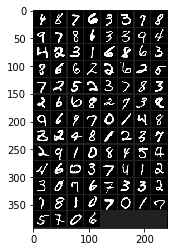

In [518]:
in_names = [str(i%28) +","+ str(int(i/28)) for i in range(28*28)]
out_names = [str(i) for i in range(10)]
imgs,labels = iter(train_loader).next()
size = 28*28
gnn = graph_neural_network(size,10,h_edges=5,in_names=in_names,out_names=out_names)
imshow(torchvision.utils.make_grid(imgs))

## 

In [519]:
print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 600
==>>> total testing batch number: 100


In [520]:
size = 28*28
gnn = graph_neural_network(size,10,h_edges=5,in_names=in_names,out_names=out_names)
gnn2 = graph_neural_network(size,10,h_edges=5)
fc = nn.Sequential(nn.Linear(size,50),nn.ReLU(),nn.Linear(50,10))
criterion = nn.CrossEntropyLoss()

In [521]:
models = [0,0]
tags = ["GNN cos", "GNN rand"]

In [522]:
for epoch in range(120):
    for i in range(10):
        gnn.add_random_hidden()
        gnn2.add_random_hidden()
    gnn.create_nn()
    models[0] = gnn.nn
    gnn2.create_nn()
    models[1] = gnn2.nn
    for model, tag in zip(models,tags):
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        # trainning
        ave_loss = 0
        for batch_idx, (x, target) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.view(batch_size,-1)
            out = F.softmax(model(x),dim=1)
            loss = criterion(out, target)
            ave_loss = ave_loss * 0.9 + loss.item() * 0.1
            loss.backward()
            optimizer.step()
            #if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            #    print('==>>> {}: epoch {}, batch index: {}, train loss: {:.6f}'.format(tag,
            #        epoch, batch_idx+1, ave_loss))

        # testing
        correct_cnt, ave_loss = 0, 0
        total_cnt = 0
        for batch_idx, (x, target) in enumerate(test_loader):
            x = x.view(batch_size,-1)
            out = F.softmax(model(x),dim=1)
            loss = criterion(out, target)
            _, pred_label = torch.max(out.data, 1)
            total_cnt += x.data.size()[0]
            correct_cnt += int((pred_label == target.data).sum())
            # smooth average
            ave_loss = ave_loss * 0.9 + loss.item() * 0.1

            if(batch_idx+1) == len(test_loader):
                print('==>>> {}: epoch {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(tag,
                    epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / float(total_cnt)))

    gnn.update_graph()
    for i in range(10):
        loader = iter(train_loader)
        samples = 0
        X, y = [], []
        while(samples < 5000):
            X_t, y_t = loader.next()
            X.append(X_t.view(batch_size,-1))
            y.append(y_t)
            samples += batch_size
        samples = 0
        gnn.add_cossim_hidden(X,y,out=i)
        gnn2.add_random_hidden()

==>>> GNN cos: epoch 0, batch index: 100, test loss: 2.162555, acc: 0.299
==>>> GNN rand: epoch 0, batch index: 100, test loss: 2.235752, acc: 0.196
['0.25(12,19)', '-0.24(8,14)', '-0.24(8,13)', '-0.24(7,14)', '0.23(15,10)'] -> ['0']
['0.34(unselfish-viridian-oriole-of-piety)', '0.32(14,5)', '0.32(20,18)', '0.32(20,17)', '0.31(15,5)'] -> ['1']
['0.24(14,10)', '0.23(15,10)', '0.22(14,11)', '0.22(15,9)', '0.22(14,9)'] -> ['2']
['0.26(13,19)', '0.25(12,20)', '0.25(12,19)', '0.24(13,20)', '0.23(11,20)'] -> ['3']
['0.29(15,4)', '0.28(12,20)', '0.28(14,4)', '0.28(12,19)', '0.27(14,5)'] -> ['4']
['0.30(14,5)', '0.30(15,5)', '0.27(14,4)', '0.26(15,4)', '0.26(12,19)'] -> ['5']
['0.31(15,10)', '0.28(15,9)', '0.27(15,11)', '0.26(14,11)', '0.26(16,9)'] -> ['6']
['0.46(18,19)', '0.45(18,18)', '0.45(17,19)', '0.45(17,20)', '0.44(19,18)'] -> ['7']
['0.27(15,10)', '0.27(14,10)', '0.27(19,18)', '0.27(15,4)', '0.27(15,9)'] -> ['8']
['0.29(12,20)', '0.29(15,4)', '0.28(14,4)', '0.28(14,5)', '0.28(16,4)'] 

KeyboardInterrupt: 

In [ ]:
for z in zero_ins:
    if len(z) == 2:
        print(z[0],z[1])

In [ ]:
for o in one_ins:
    if len(o) == 2:
        print(o[0],o[1])